In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("data_clean.csv")
df = df.drop(df.columns[0], axis = 1)
display(df.head())
df.shape

,date,year,gold,agnico,coal,copper,dax,dji,djt,eur,...,nasdaq,newmont,n_gas,oil,palladium,platinum,rgold,rio,silver,snp
0,2016-01-04,2016,1078.47,26.94,49.90,25.66,348.83,17148.94,7352.59,1.08,...,4903.09,18.44,2.33,36.76,544.55,881.65,37.18,28.41,13.98,2012.66
1,2016-01-05,2016,1079.33,27.62,50.25,25.95,350.98,17158.66,7363.95,1.07,...,4891.43,18.42,2.33,35.97,536.20,890.30,36.49,28.65,13.97,2016.71
2,2016-01-06,2016,1098.90,28.45,51.50,25.20,350.07,16906.51,7217.05,1.08,...,4835.76,18.56,2.27,33.97,505.60,879.55,37.02,27.03,14.07,1990.26
3,2016-01-07,2016,1103.45,29.99,51.25,24.56,341.24,16514.10,6995.39,1.09,...,4689.43,18.86,2.38,33.27,493.50,875.55,38.74,25.81,14.20,1943.09
4,2016-01-08,2016,1104.32,29.56,50.25,24.07,338.23,16346.45,6946.36,1.09,...,4643.63,18.01,2.47,33.16,494.20,880.00,37.59,25.07,13.94,1922.03


(1893, 21)

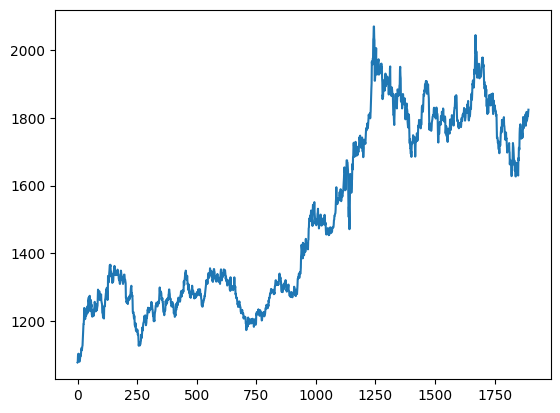

In [92]:
plt.plot(df.gold)
plt.show()

In [3]:
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

### FUNCTION SHIFT PRICE

In [38]:
def shift_price(df, days_ahead):
    dftry = df.copy()
    dftry = df.reset_index(drop = True)
    dftry_gold = dftry[["date","gold"]].copy()
    dftry_ngold = dftry.drop("gold", axis = 1)
    hidden = dftry_ngold.iloc[-days_ahead:]
    dftry_ngold = dftry_ngold.shift(days_ahead, axis = 0)
    dftry = [dftry_gold, dftry_ngold]
    dftry = pd.concat(dftry, axis = 1)
    dftry = dftry.iloc[days_ahead:]
    new = dftry.iloc[-days_ahead:]
    data = dftry.iloc[0:-days_ahead]
    return new, data, hidden

### all prediction methods as functions

In [42]:
def linreg_predict(xtrain, xtest , xnew, ytrain, ytest, ynew, hidden):
    regr = linear_model.LinearRegression()
    regr.fit(xtrain, ytrain)

    pred_train = regr.predict(xtrain)
    r2_train = r2_score(ytrain, pred_train)

    pred_test = regr.predict(xtest)
    r2_test = r2_score(ytest, pred_test)
    
    pred_new = regr.predict(xnew)
    r2_new = r2_score(ynew, pred_new)

    pred_hidden = regr.predict(hidden)
    pred_hidden = pd.DataFrame(pred_hidden, columns = ["linreg"])
    pred_hidden = round(pred_hidden,2)

    return r2_train, r2_test, r2_new, pred_hidden

In [74]:
def mlp_predict(xtrain, xtest, xnew, ytrain, ytest, ynew, hidden):
    regr = MLPRegressor(random_state = 46, max_iter = 700)
    regr.fit(xtrain, ytrain)

    r2_train = regr.score(xtrain, ytrain)
    r2_test = regr.score(xtest, ytest)
    r2_new = regr.score(xnew, ynew)

    pred_hidden = regr.predict(hidden)
    pred_hidden = pd.DataFrame(pred_hidden, columns = ["mlp"])
    pred_hidden = round(pred_hidden,2)
    
    return r2_train, r2_test, r2_new, pred_hidden

In [76]:
def knn_predict(xtrain, xtest, xnew, ytrain, ytest, ynew, hidden):
    regr = KNeighborsRegressor(n_neighbors=5, p = 1)
    regr.fit(xtrain, ytrain)

    r2_train = regr.score(xtrain, ytrain)
    r2_test = regr.score(xtest, ytest)
    r2_new = regr.score(xnew, ynew)

    pred_hidden = regr.predict(hidden)
    pred_hidden = pd.DataFrame(pred_hidden, columns = ["knn"])
    pred_hidden = round(pred_hidden,2)
    
    return r2_train, r2_test, r2_new, pred_hidden

In [63]:
def rforest_predict(xtrain, xtest, xnew, ytrain, ytest, ynew, hidden):
    regr = RandomForestRegressor(max_depth = 2, random_state = 31)
    regr.fit(xtrain, ytrain)

    r2_train = regr.score(xtrain, ytrain, sample_weight = None)
    r2_test = regr.score(xtest, ytest, sample_weight = None)
    r2_new = regr.score(xnew, ynew, sample_weight = None)

    pred_hidden = regr.predict(hidden)
    pred_hidden = pd.DataFrame(pred_hidden, columns = ["random_forest"])
    pred_hidden = round(pred_hidden,2)

    return r2_train, r2_test, r2_new, pred_hidden

### other functions

In [85]:
def drop_corr(df):
    corr = df.corr()
    to_drop = corr.index[corr.gold < 0.8].tolist()
    return to_drop

In [90]:
def run_predictions(df, target, days_ahead):
    new, data, hidden = shift_price(df, days_ahead)
    to_drop = drop_corr(data)
    X = data.drop(target + to_drop, axis = 1)
    y = data[target].copy()
    X_new = new.drop(target + to_drop, axis = 1)
    y_new = new[target].copy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=76)
    X_hidden = hidden.drop(to_drop, axis = 1)
    num_train = X_train.select_dtypes(np.number)
    num_test = X_test.select_dtypes(np.number)
    num_new = X_new.select_dtypes(np.number)
    num_hidden = X_hidden.select_dtypes(np.number)

    transformer = MinMaxScaler().fit(num_train)
    xtrain = transformer.transform(num_train)
    xtest = transformer.transform(num_test)
    xnew = transformer.transform(num_new)
    xhidden = transformer.transform(num_hidden)

    a1,b1,c1,d1 = linreg_predict(xtrain, xtest, xnew, y_train, y_test, y_new, xhidden)
    a2,b2,c2,d2 = mlp_predict(xtrain, xtest, xnew, y_train, y_test, y_new, xhidden)
    a3,b3,c3,d3 = knn_predict(xtrain, xtest, xnew, y_train, y_test, y_new, xhidden)
    a4,b4,c4,d4 = rforest_predict(xtrain, xtest, xnew, y_train, y_test, y_new, xhidden)

    return a1,b1,c1,d1,a2,b2,c2,d2,a3,b3,c3,d3,a4,b4,c4,d4

In [34]:
import warnings
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
from sklearn.exceptions import DataConversionWarning
simplefilter("ignore", category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
pd.options.mode.chained_assignment = None

In [65]:
def get_result(df, target, days_ahead):
    new_data_size = []
    lr_train = []
    lr_test = []
    lr_new = []
    mlp_train = []
    mlp_test = []
    mlp_new = []
    knn_train = []
    knn_test = []
    knn_new = []
    r_forest_train = []
    r_forest_test = []
    r_forest_new = []
    pred_linreg = []
    pred_mlp = []
    pred_knn = []
    pred_abr = []
    pred_r_forest = []
    res = pd.DataFrame()
    new_scores = pd.DataFrame()
    best_score = []
    
    for i in days_ahead:
        new_data_size.append(i)
        a1,b1,c1,d1,a2,b2,c2,d2,a3,b3,c3,d3,a4,b4,c4,d4 = run_predictions(df, target, i)
        lr_train.append(a1)
        lr_test.append(b1)
        lr_new.append(c1)
        mlp_train.append(a2)
        mlp_test.append(b2)
        mlp_new.append(c2)
        knn_train.append(a3)
        knn_test.append(b3)
        knn_new.append(c3)
        r_forest_train.append(a4)
        r_forest_test.append(b4)
        r_forest_new.append(c4)
        pred_linreg.append(d1)
        pred_mlp.append(d2)
        pred_knn.append(d3)
        pred_r_forest.append(d4)
        best_score.extend([c1,c2,c3,c4])
    
    res["new_data_size"] = new_data_size
    res["linreg_train"] = lr_train
    res["linreg_test"] = lr_test
    res["linreg_new"] = lr_new
    res["mlp_train"] = mlp_train
    res["mlp_test"] = mlp_test
    res["mlp_new"] = mlp_new
    res["knn_train"] = knn_train
    res["knn_test"] = knn_test
    res["knn_new"] = knn_new
    res["random_forest_train"] = r_forest_train
    res["random_forest_test"] = r_forest_test
    res["random_forest_new"] = r_forest_new
    
    # make some sound to notify when the process finishes. this could take like until 45 mins, 
    # depending on the iteration
    import winsound
    import time
    do = 500
    duration = 900
    for i in range(3):
        winsound.Beep(do, duration)
        time.sleep(.2)

    return res

In [36]:
def display_all_max_r2(res):
    print("Linear Regression")
    print("highest prediction score in Linear Regression:", res.linreg_new.max())
    display(res.loc[res.linreg_new == res.linreg_new.max(), ["new_data_size","linreg_train","linreg_test","linreg_new"]])
    print("\n\nMulti-Layer-Perceptron")
    print("highest prediction score in Multi-Layer Perceptron:", res.mlp_new.max())
    display(res.loc[res.mlp_new == res.mlp_new.max(), ["new_data_size","mlp_train","mlp_test","mlp_new"]])
    print("\n\nK-Nearest Neighbors")
    print("highest prediction score in K-Nearest Neighbors:", res.knn_new.max())
    display(res.loc[res.knn_new == res.knn_new.max(), ["new_data_size","knn_train","knn_test","knn_new"]])
    print("\n\nRandom Forest")
    print("highest prediction score in Random Forest:", res.random_forest_new.max())
    display(res.loc[res.random_forest_new == res.random_forest_new.max(), ["new_data_size","random_forest_train","random_forest_test","random_forest_new"]])
    

### execute

In [91]:
target = ["gold"]
days_ahead = range(2,941,2)
res= get_result(df, target, days_ahead)
display_all_max_r2(res)

Linear Regression
highest prediction score in Linear Regression: 0.5543048320727553


,new_data_size,linreg_train,linreg_test,linreg_new
120,242,0.83275,0.827202,0.554305




Multi-Layer-Perceptron
highest prediction score in Multi-Layer Perceptron: -1.3093476148369971


,new_data_size,mlp_train,mlp_test,mlp_new
15,32,0.006638,-0.020914,-1.309348




K-Nearest Neighbors
highest prediction score in K-Nearest Neighbors: 0.514231030096519


,new_data_size,knn_train,knn_test,knn_new
114,230,0.988227,0.986103,0.514231




Random Forest
highest prediction score in Random Forest: 0.19958226585320638


,new_data_size,random_forest_train,random_forest_test,random_forest_new
132,266,0.929226,0.936161,0.199582


In [ ]:
target = ["gold"]
days_ahead = 
a1,b1,c1,d1,a2,b2,c2,d2,a3,b3,c3,d3,a4,b4,c4,d4 = run_predictions(df, days_ahead, target)